Esse video demostra como fazer transferlearning usando a arquitetura resnet50:
https://youtu.be/JcU72smpLJk?si=SlN3V24ACvQqllQt

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Preparing The Data

baixa o dataset da intenet e o armazena localmente, o arquivo é renomeado apos ser descompactado e o armazena em um objeto

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


In [4]:
print(data_dir)

/home/takana/.keras/datasets/flower_photos


/home/takana/.keras/datasets/flower_photos/roses/8524505546_b242bd4928_n.jpg


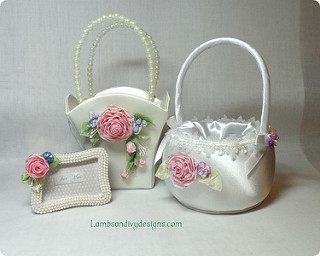

In [8]:
roses = list(data_dir.glob('roses/*'))
print(roses[0])
PIL.Image.open(str(roses[0])) #mostra a primeira imagem do diretorio

Hyperparametros

In [41]:
#Define a altura e largura das imagens para redimensioná-las ao carregar (180x180 pixels) e o tamanho do lote (batch) de 32 imagens, para o treinamento.
img_height,img_width=180,180
batch_size=32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#validation_split=0.2: 20% das imagens são reservadas para validação.
#subset="training": especifica que estamos criando o conjunto de treinamento.
#seed=123: assegura que a divisão de treino/validação seja a mesma em execuções diferentes.
#image_size: redimensiona as imagens para 180x180 pixels.
#batch_size: define o tamanho do lote de dados.

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [42]:
class_names = train_ds.class_names
print(class_names) #Obtém e imprime os nomes das classes, que correspondem aos subdiretórios presentes no dataset.

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


2024-10-08 19:04:10.059927: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


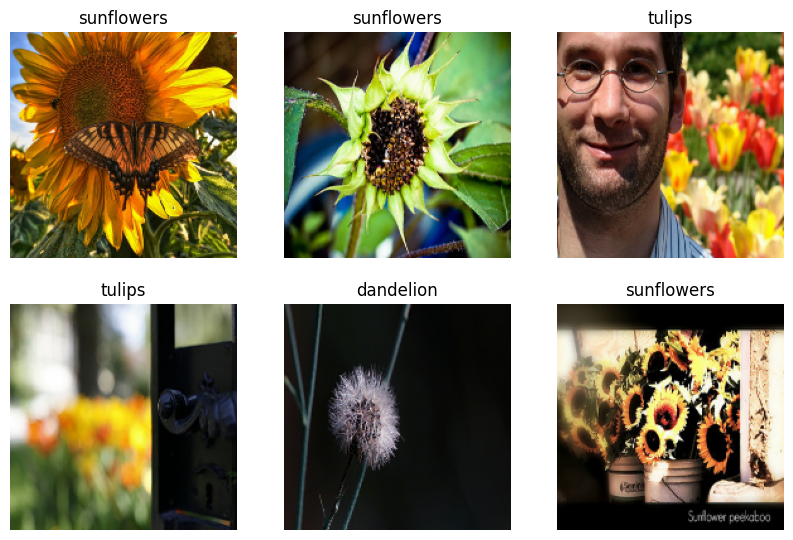

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Training The Model

In [22]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Dense
#Importa o modelo ResNet50 pré-treinado da biblioteca keras.applications, que contém vários modelos famosos com pesos pré-treinados.
#Flatten e Dense: são camadas que serão adicionadas para personalizar a rede com base nas necessidades da tarefa de classificação.

resnet_model = Sequential() #Cria uma instância de Sequential, que é uma maneira de empilhar camadas de forma linear. 
#Esse será o modelo principal onde você vai adicionar as camadas

pretrained_model = ResNet50(include_top=False, weights='imagenet', input_shape=(180, 180, 3))
#ResNet50: Carrega o modelo ResNet50 pré-treinado, mas exclui a camada de classificação final (include_top=False), pois queremos personalizar a classificação.
#weights='imagenet': Indica que os pesos são pré-treinados no dataset ImageNet, que possui uma grande variedade de classes.
#input_shape=(180, 180, 3): Define o tamanho de entrada para as imagens, que aqui são de 180x180 pixels e com 3 canais de cor (RGB).

for layer in pretrained_model.layers:
    layer.trainable = False
#Congela as camadas da ResNet50, impedindo que os pesos sejam atualizados durante o treinamento. 
#Isso é feito para aproveitar o aprendizado já existente da ResNet50, reduzindo o custo computacional e prevenindo sobreajuste com o novo conjunto de dados.


resnet_model.add(pretrained_model) #Adiciona o pretrained_model como a primeira camada do resnet_model. 
#Assim, todo o aprendizado da ResNet50 será usado como uma base para o novo modelo.

resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(5, activation='softmax'))
#Flatten(): Transforma a saída tridimensional da ResNet50 em uma forma unidimensional, permitindo a conexão com camadas densas (fully connected).
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
#Dense(512, activation='relu'): Adiciona uma camada densa de 512 neurônios com função de ativação ReLU, ajudando a rede a aprender padrões complexos 
#a partir das features extraídas pela ResNet50.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
#Dense(5, activation='softmax'): Adiciona a camada de saída para a classificação final, onde o número de neurônios (5) corresponde ao número de classes 
#no dataset de flores. A função softmax converte as saídas em probabilidades, sendo usada para classificação multiclasses.

In [23]:
resnet_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 6, 6, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    37,749,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,339,525 (233.99 MB)

 Trainable params: 37,751,813 (144.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [30]:
resnet_model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',  # Altere para sparse_categorical_crossentropy
    metrics=['accuracy']
)
#optimizer=Adam(): Define o otimizador que será usado para ajustar os pesos do modelo durante o treinamento.
#Adam é um otimizador amplamente usado que combina as vantagens de dois métodos: AdaGrad e RMSProp. Ele ajusta a taxa de aprendizado durante o treinamento, 
#o que costuma acelerar a convergência.

#loss='sparse_categorical_crossentropy': Define a função de perda como sparse_categorical_crossentropy.
#Essa função de perda é usada para classificação multiclasse quando os rótulos (labels) são inteiros (por exemplo, 0, 1, 2) em vez de codificados em one-hot.
#Se as classes já estivessem em formato one-hot (matriz onde apenas um valor é 1 e os outros 0), seria usada categorical_crossentropy.
#metrics=['accuracy']: Define a métrica de desempenho que será monitorada durante o treinamento e validação.

#accuracy mede a proporção de previsões corretas, sendo uma métrica comum para problemas de classificação.

In [31]:
epochs=10 #Define a quantidade de vezes que o modelo verá o conjunto de treinamento completo
history = resnet_model.fit( #fit(): Esse método executa o treinamento do modelo, ajustando os pesos de acordo com a função de perda e o otimizador definidos.
  train_ds, 
  validation_data=val_ds,
  epochs=epochs
)
#train_ds: O conjunto de dados de treinamento que o modelo utilizará para aprender. Deve estar previamente configurado para fornecer lotes (batches) de dados ao modelo.
#----
#validation_data=val_ds: Conjunto de dados de validação. Ao especificar o parâmetro validation_data, o modelo avaliará o desempenho após cada época.
#O val_ds ajuda a verificar se o modelo está generalizando bem, e não apenas se ajustando aos dados de treinamento.
#----
#epochs=epochs: Indica quantas vezes o modelo passará pelos dados de treinamento.
# _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
#A variável history guarda informações sobre o treinamento, como os valores de perda e acurácia por época. Isso é útil para visualizações e 
#análise de desempenho ao longo do treinamento.

Epoch 1/10


I0000 00:00:1728429469.338280    1375 service.cc:146] XLA service 0x7fbbe8003010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728429469.338399    1375 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-10-08 19:17:49.441837: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-08 19:17:50.034318: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-08 19:17:54.429423: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5640', 4 bytes spill stores, 4 bytes spill loads



 7/92 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.2133 - loss: 56.4445

I0000 00:00:1728429476.846362    1375 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 115ms/step - accuracy: 0.6086 - loss: 18.3196 - val_accuracy: 0.7984 - val_loss: 1.3784
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9404 - loss: 0.3404 - val_accuracy: 0.8134 - val_loss: 1.2692
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9695 - loss: 0.1574 - val_accuracy: 0.8256 - val_loss: 1.1802
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9818 - loss: 0.0638 - val_accuracy: 0.8583 - val_loss: 1.3392
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9936 - loss: 0.0197 - val_accuracy: 0.8610 - val_loss: 1.1090
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9950 - loss: 0.0197 - val_accuracy: 0.8665 - val_loss: 1.2430
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9952 - loss: 0.0128 - val_accuracy: 0.8597 - val_loss: 1.2203
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.9988 - loss: 0.0053 - val_accuracy: 0.8651 - val_loss:

# Evaluating The Model

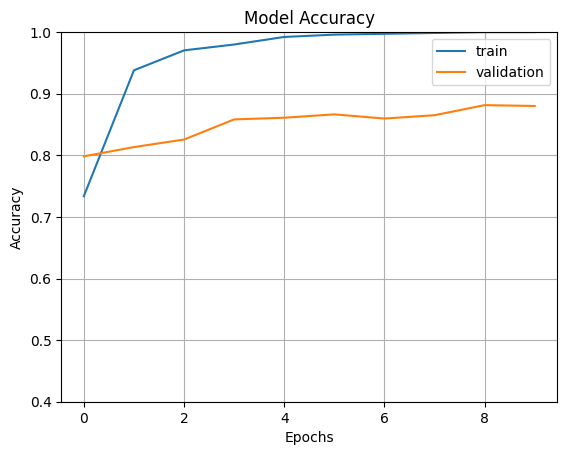

In [32]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

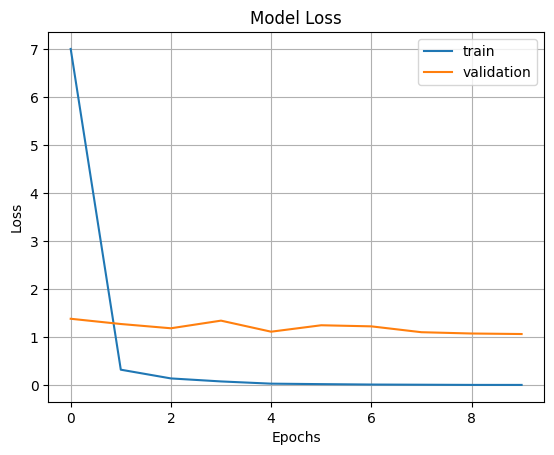

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()
     

# Making Predictions

In [43]:
import cv2

image=cv2.imread(str(roses[0]))
image_resized= cv2.resize(image, (img_height,img_width))
image=np.expand_dims(image_resized,axis=0)
print(image.shape)

#cv2.imread(): Carrega uma imagem de um arquivo. A imagem é lida no formato BGR por padrão (não RGB), o que é importante lembrar
#se você estiver realizando outras operações que dependem do canal de cores.
#---------------------------------------------------------------------------------------------------------------------------------
#str(roses[0]): Supondo que roses é uma lista de caminhos de imagens, o primeiro item (roses[0]) é o caminho da imagem que está sendo carregada. 
#str() é usado para converter o caminho em string, se não estiver no formato de texto.
#---------------------------------------------------------------------------------------------------------------------------------
#cv2.resize(): Redimensiona a imagem carregada para o tamanho esperado pelo modelo.
#img_height e img_width: São as dimensões de altura e largura definidas anteriormente no código (180x180), que o modelo espera como entrada.
#---------------------------------------------------------------------------------------------------------------------------------
#np.expand_dims(): Adiciona uma dimensão extra ao array da imagem. Isso é feito para que a imagem tenha o formato (1, img_height, img_width, 3), 
#onde 1 representa o número de amostras (neste caso, apenas uma imagem).
#O modelo espera os dados de entrada neste formato com o lote (batch size) como a primeira dimensão.

(1, 180, 180, 3)


In [38]:
pred=resnet_model.predict(image) 
print(pred)
#resnet_model.predict(image): Usa o modelo resnet_model para prever a classe da imagem processada. O modelo retorna uma array de probabilidades para cada classe.
#image: A imagem que foi redimensionada e preparada para ter a forma correta ((1, 180, 180, 3)).
#pred armazena as previsões de probabilidade de cada classe.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[5.2108667e-21 6.5913861e-14 1.0000000e+00 1.7130703e-13 2.3889939e-08]]


In [39]:
output_class=class_names[np.argmax(pred)]
print("The predicted class is", output_class)
#np.argmax(pred): Retorna o índice da classe com a maior probabilidade.
#class_names[...]: Usa o índice retornado por np.argmax(pred) para obter o
#nome da classe correspondente da lista class_names, que contém os rótulos das classes (por exemplo, "rose", "daisy").

The predicted class is roses
